In [1]:
%load_ext autoreload

In [2]:
import sys
sys.path.append('/home/greco/git_repos/mlreflect/')

import matplotlib.pyplot as plt
import numpy as np

from mlreflect import ReflectivityGenerator, InputPreprocessor, OutputPreprocessor, Prediction
from mlreflect import h5_tools
from mlreflect.models.simple_model import SimpleModel

Using TensorFlow backend.
/home/greco/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/greco/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/greco/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/greco/anaconda3/lib/python3.7/site-packages/tensorflo

In [3]:
experiment = np.loadtxt('DIP_303K.txt')

q = experiment[:, 0]

In [4]:
params = {'thickness': [(20.0, 300.0), (2.8, 30), (100.0, 100.0)], 'roughness': [(0.0, 60.0), (2.5, 2.5), (1.0, 1.0)],
          'SLD': [(1.0, 14.0), (17.8, 17.8), (20.1, 20.1)]}

thickness_ranges = params['thickness']
roughness_ranges = params['roughness']
sld_ranges = params['SLD']

In [5]:
rg = ReflectivityGenerator(q, 0)
random_labels = rg.generate_random_labels(thickness_ranges, roughness_ranges, sld_ranges, 22500)
random_reflectivity = rg.simulate_reflectivity(random_labels)

  1%|          | 117/22500 [00:00<00:19, 1167.90it/s]

Finished 'generate_random_labels' in 0.2094 secs


100%|██████████| 22500/22500 [00:19<00:00, 1164.37it/s]

Finished 'simulate_reflectivity' in 19.3610 secs


In [6]:
train_labels = random_labels[:20000].reset_index(drop=True)
val_labels = random_labels[20000:22000].reset_index(drop=True)
test_labels = random_labels[22000:].reset_index(drop=True)

In [7]:
train_reflectivity = random_reflectivity[:20000, :]
val_reflectivity = random_reflectivity[20000:22000, :]
test_reflectivity = random_reflectivity[22000:, :]

In [8]:
h5_tools.save_data_as_h5('output/saved_training_data.h5', 'train', q, train_reflectivity, train_labels)
h5_tools.save_data_as_h5('output/saved_training_data.h5', 'val', q, val_reflectivity, val_labels)
h5_tools.save_data_as_h5('output/saved_training_data.h5', 'test', q, test_reflectivity, test_labels)

In [9]:
# loaded_data = h5_tools.read_from_h5('saved_training_data.h5', 'train')

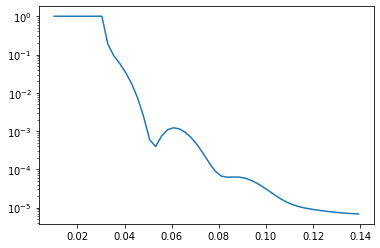

In [10]:
plt.semilogy(q, train_reflectivity[0, :])
plt.show()

In [11]:
ip = InputPreprocessor()

ip.append_to_job_list(ip.log)
ip.append_to_job_list(ip.standardize)

In [12]:
train_reflectivity_pp = ip.apply_preprocessing(train_reflectivity)
val_reflectivity_pp = ip.apply_preprocessing(val_reflectivity)
test_reflectivity_pp = ip.apply_preprocessing(test_reflectivity)

In [13]:
op = OutputPreprocessor(thickness_ranges, roughness_ranges, sld_ranges)

train_labels_pp = op.apply_preprocessing(train_labels)
val_labels_pp = op.apply_preprocessing(val_labels)
test_labels_pp = op.apply_preprocessing(test_labels)

In [14]:
print(train_reflectivity_pp.shape[1], train_labels_pp.shape[1])

52 4


In [ ]:
simple_model = SimpleModel('output/simple_model', train_reflectivity_pp.shape[1], train_labels_pp.shape[1])
hist = simple_model.train(train_reflectivity_pp, train_labels_pp, val_reflectivity_pp, val_labels_pp)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               21200     
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 800)               320800    
_________________________________________________________________
activation_2 (Activation)    (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               320400    
_________________________________________________________________
activation_3 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               120300    
_______

In [ ]:
pr = Prediction('output/simple_model/simple_model_', op.used_label_names)

In [ ]:
pred_test_labels = pr.predict_labels(test_reflectivity_pp)

In [ ]:
test_labels_pp

In [ ]:
pred_test_labels

In [ ]:
pred_test_labels.reset_index(drop=True) - test_labels_pp.reset_index(drop=True)

In [ ]:
mape = pr.mean_absolute_percentage_error(pred_test_labels, test_labels_pp)
print(mape)

In [ ]:
mae = pr.mean_absolute_error(pred_test_labels, test_labels_pp)
print(mae)

In [ ]:
test_labels

In [ ]:
restored_pred_test_labels = op.restore_labels(pred_test_labels, test_labels)

In [ ]:
restored_pred_test_labels

In [ ]:
plt.plot(restored_pred_test_labels['layer2_thickness'], test_labels['layer2_thickness'], '.')
plt.plot(restored_pred_test_labels['layer2_thickness'], restored_pred_test_labels['layer2_thickness'])

In [ ]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.show()
plt.semilogy(hist.history['loss'], label='loss')
plt.semilogy(hist.history['val_loss'], label='val_loss')
plt.show()

In [ ]:
pred_test_reflectivity = rg.simulate_reflectivity(restored_pred_test_labels)